#Initialization

1. Get all of the imports.
2. Define a helper function which displays twelve faces in a grid.
3. Get the UMass dataset and read into the NumPy array.
4. Set height and width variables (h, w) for future use and split the George W Bush faces into a training and testing set

### General notes on usage:

fetch_lfw_people (flp) returns a dictionary-like object. It returns two different representations of the pictures:
1. .images is an array of 2D images (so a 3D array), while
2. .data "stretches" the image out into one array (so row after row), making it a 2D array.

Using .images is easier if you are displaying theimages while using .data makes it *much* easier to do calculations and transformations on the data.

So I will use .data and reshape it when I need to display the pictures; the other way around makes it way too complicated.

-----

When I subtract the mean from an individual face, I add the "norm" label to either the set or the variable that has been normalized.

In [31]:
import tarfile
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

"""          Helper function to plot a gallery of labeled portraits          """
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [32]:
# Get the data from UMass website
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz 
!wget http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt
!wget http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt
!wget http://vis-www.cs.umass.edu/lfw/pairs.txt

# Extract the data set
tfile = tarfile.open("lfw-deepfunneled.tgz", "r:gz")
tfile.extractall("lfw_home/.")

# Move to the lfw_funneled folder
!mv lfw_home/lfw-deepfunneled lfw_home/lfw_funneled
!mv pairsDevTrain.txt lfw_home/.
!mv pairsDevTest.txt lfw_home/.
!mv pairs.txt lfw_home/.

--2023-02-03 04:38:44--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘lfw-deepfunneled.tgz.1’

lfw-deepfunneled.tg 100%[===================>] 103.72M  76.4MB/s    in 1.4s    

2023-02-03 04:38:45 (76.4 MB/s) - ‘lfw-deepfunneled.tgz.1’ saved [108761145/108761145]

--2023-02-03 04:38:45--  http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56579 (55K) [text/plain]
Saving to: ‘pairsDevTrain.txt’

pairsDevTrain.txt   100%[===================>]  55.25K  --.-KB/s    in 0.05s   

2023-02-03 04:38:46 (1014 KB/

In [33]:
# Get the whole data set and just the George W Bush faces
# - the 2nd command get GWB faces b/c he is the only one with 500+ labeled faces
lfw_people = fetch_lfw_people(min_faces_per_person=70,  resize=0.5, data_home=".", download_if_missing=False)
gwb =        fetch_lfw_people(min_faces_per_person=530, resize=0.5, data_home=".", download_if_missing=False)

# Split the GWB faces set into training and testing sets
gwb_train, gwb_test = train_test_split(gwb.data, test_size=0.15)

_, h, w = lfw_people.images.shape #should be h:62, w:47

# Training

The first step is to change the "origin" of the vectors (faces) from the origin to the mean of the faces.

1. Find the mean
2. Subtract the mean from each face (called normalization)

Then you work towards finding the eigenvectors

1. Calculate the covariance matrix
2. Calculate the eiegenvectors of the covariance matrix

In [34]:
# Normalize the GWB faces
meanGwb = np.mean(gwb_train, axis=0)
gwb_data_norm = gwb_train - meanGwb

# Calculate the eigenvalues and eigenvectors from the covariance matrix
covarMtx = np.dot(gwb_data_norm.transpose(), gwb_data_norm) / (gwb_data_norm.shape[0]-1)
e_vals, e_vecs = np.linalg.eig(covarMtx)

Each eigenvector (column in the covariance matrix) represents some of the features that characterize GWB's face. However, some account for more of the variance than others (some represent his face well, others are basically static).

This is where Principle Component Analysis comes in. We can take out the eigenfaces which account for the least amount of variance, which reduces the dimensionality of the data without significantly reducing our classification ability.

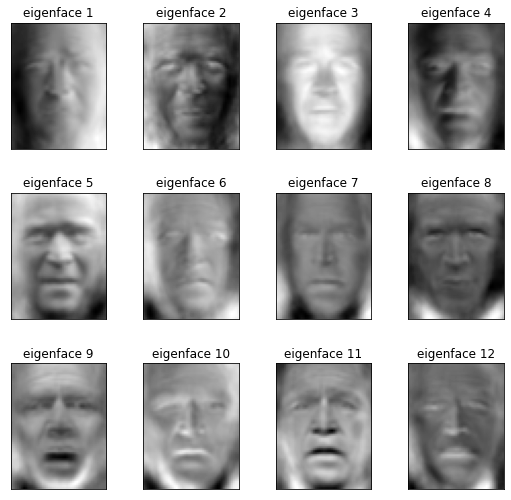

In [35]:
# Sort vectors based on values
sort = np.argsort(e_vals)[::-1]
e_vals = e_vals[sort]
e_vecs = e_vecs[: , sort]

# Find amount of values required to get to at least 95% of the variance
tv = np.sum(e_vals)
i = 0
var = 0
sum = 0
while var < 0.95:
    sum += e_vals[i]
    var = sum/tv
    i += 1

# The principle components
topFaces = e_vecs[:, :i].T

# Plot the first twelve eigenfaces
labels = ["eigenface %d" % (i+1)  for i in range(12)]
plotFaces = [face.reshape(h, w) for face in topFaces[0:12]]
plot_gallery(plotFaces, labels, h, w)

Eigenface 9 always makes me chuckle.

# Testing

To classify the images, we project a normalized image into vector space and find the distance to the GWB mean eigenface. If it is smaller than some threshold, we classify the face as George W Bush, otherwise it is someone else.

However, when I looked at the distances I was getting, I found no significant difference between the faces that were and were not GWB. So any attempt to run this would result in no better accuracy than pure guessing.

In [36]:
# Find the mean eigenface of the top faces (mean of all produces nothing)
avg_eface = np.mean(topFaces, axis=0) / topFaces.shape[0]

diffs = []
for face in gwb_test:
    # Center the face for comparison by removing the mean
    normFace = face - meanGwb

    # Project the normalized face into eigenspace
    projection = np.matmul(normFace, e_vecs)

    # Find difference (distance between two points)
    diff = np.linalg.norm(avg_eface - projection)

    diffs.append(diff)

print(min(diffs))
print(np.mean(diffs))
print(max(diffs))

1334.4679
2112.3833
3500.0442


This code cell was where I first got the distance calculation after projecting the face into eigenspace working. Initially, I was hopeful because I saw some distances in the 8,000's in class. If the other faces had around that distance, I could set the threshold around 4,000 which would likely classify the faces pretty accurately.

In the following code cell, I found the distance between the mean GWB eigenface and the projected mean face. Once again, these results gave me hope that I was on the right track. Alas. Maybe if I removed the GWB faces from the mean face calculation the number would have been more accurate.

In [37]:
# Find distance between mean overall face and mean gwb eigenface
# This should help set the threshold
meanFace = np.mean(lfw_people.data, axis=0)

meanFaceProj = np.matmul(meanFace, e_vecs)

np.linalg.norm(avg_eface - meanFaceProj)

7120.859

This is the real testing loop. Currently I am just recording the distances into two different arrays. This isn't working, and I have run out of time to figure out why.

In [38]:
dists = []
dists2 = []
for i in range(1250):
    # Center the face for comparison by removing the mean
    normFace = lfw_people.data[i] - meanGwb

    # Project the normalized face into eigenspace
    projection = np.matmul(normFace, e_vecs)

    # Find difference (distance between two points)
    diff = np.linalg.norm(avg_eface - projection)

    name = lfw_people.target_names[lfw_people.target[i]]
    #print(str(diff) + "\t" + name)

    if name != "George W Bush": dists.append(diff)
    else:                       dists2.append(diff)

print()
print(str(min(dists))     + "\t" + str(min(dists2)))
print(str(np.mean(dists)) + "\t" + str(np.mean(dists2)))
print(str(max(dists))     + "\t" + str(max(dists2)))


1119.6217	1033.1549
2209.8196	2098.683
4195.841	3760.3423


As you can see from the above two columns describing the min, mean, and max distance of the GWB and non-GWB faces, there is no clear separation in the data. I have also included two frequency graphs below to help with visualizing these sets.

It is possible that my GWB eigenfaces are too general and describe a general human face, rather than just GWB. That would explain why the numbers are not very different between the two sets.

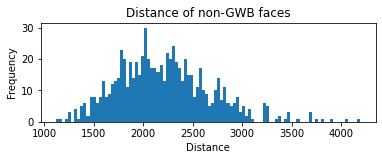

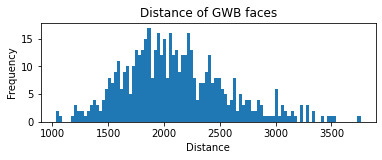

In [39]:
dist = [dists, dists2]
label = ["Distance of non-GWB faces", "Distance of GWB faces"]
for i in range(2):
    plt.subplot(2, 1, 1)
    plt.hist(dist[i], bins=100)
    plt.title(label[i])
    plt.xlabel("Distance")
    plt.ylabel("Frequency")
    plt.show()

Because there is no significant difference in the distances between the GWB and non-GWB faces, I can't do the last task of plotting the picture of a person that looks the most and least like GWB, which is really unfortunate, I was looking forward to that.